In [ ]:
!pip install tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import json
from matplotlib import pyplot as plt
import cv2

In [2]:
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

# Your output is probably something like ['/device:CPU:0']
# It should be ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
def load_image(file):
    encoded_image = tf.io.read_file(file)
    return tf.io.decode_jpeg(encoded_image)

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [6]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float64]))

In [7]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float64]))

In [8]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float64]))

In [9]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(18200, 18200, 3900, 3900, 3900, 3900)

In [10]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(20000)
train = train.batch(8)
train = train.prefetch(4)

In [11]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [12]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [14]:
vgg = VGG16(include_top=False)

In [15]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [16]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Box
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [17]:
facetracker = build_model()

In [18]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [19]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [21]:
def localizaztion_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [22]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localizaztion_loss

In [23]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker
    
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.classloss = classloss
        self.localizationloss = localizationloss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.classloss(y[0], classes)
            batch_localizationloss = self.localizationloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs):
        
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.classloss(y[0], classes)
        batch_localizationloss = self.localizationloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [24]:
model = FaceTracker(facetracker)

In [25]:
model.compile(opt, classloss, regressloss)

In [26]:
my_callbacks = [
    EarlyStopping(monitor='val_total_loss',patience=2),
    TensorBoard(log_dir='./logs_v3'),
]

In [27]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=my_callbacks)

Epoch 1/25
2275/2275 [==============================] - 1692s 668ms/step - total_loss: 0.1945 - class_loss: 0.0573 - regress_loss: 0.1659 - val_total_loss: 0.2818 - val_class_loss: 0.1399 - val_regress_loss: 0.2119
Epoch 2/25
2275/2275 [==============================] - 1649s 700ms/step - total_loss: 0.0405 - class_loss: 0.0090 - regress_loss: 0.0359 - val_total_loss: 0.0127 - val_class_loss: 0.0015 - val_regress_loss: 0.0119
Epoch 3/25
2275/2275 [==============================] - 1694s 715ms/step - total_loss: 0.0256 - class_loss: 0.0055 - regress_loss: 0.0229 - val_total_loss: 0.0144 - val_class_loss: 0.0043 - val_regress_loss: 0.0122
Epoch 4/25
2275/2275 [==============================] - 2092s 885ms/step - total_loss: 0.0132 - class_loss: 0.0017 - regress_loss: 0.0123 - val_total_loss: 0.0114 - val_class_loss: 6.0499e-06 - val_regress_loss: 0.0114
Epoch 5/25
2275/2275 [==============================] - 2199s 928ms/step - total_loss: 0.0142 - class_loss: 0.0026 - regress_loss: 0.013

In [28]:
facetracker.save('facetracker_v5.h5')

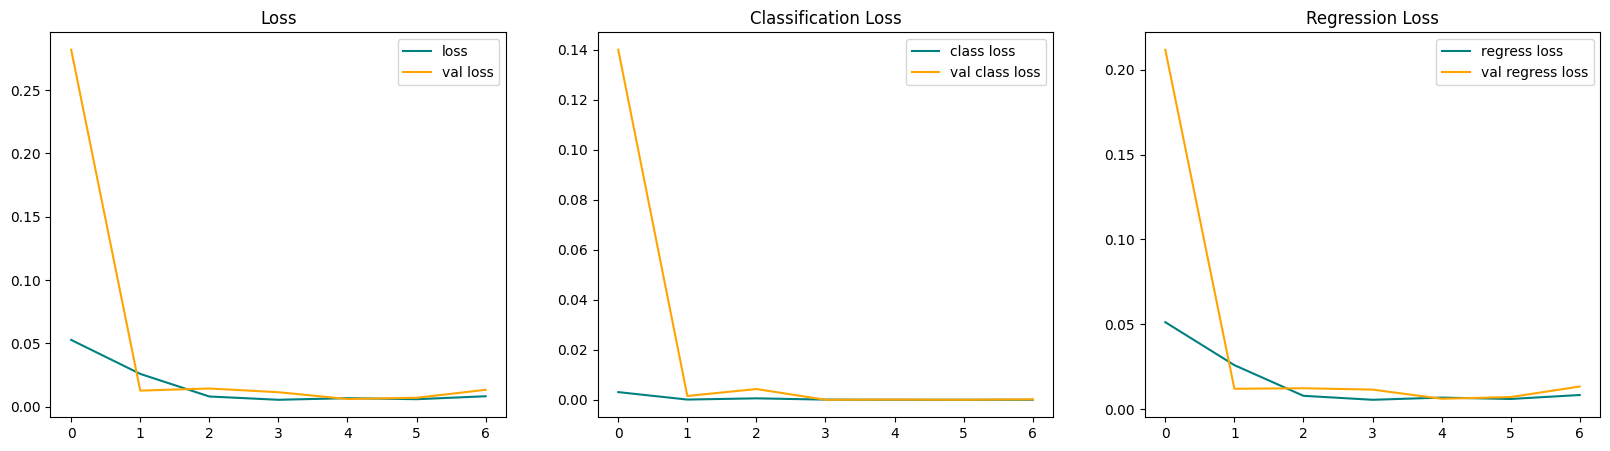

In [28]:

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [30]:
test_data = test.as_numpy_iterator()

In [33]:
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 31ms/step


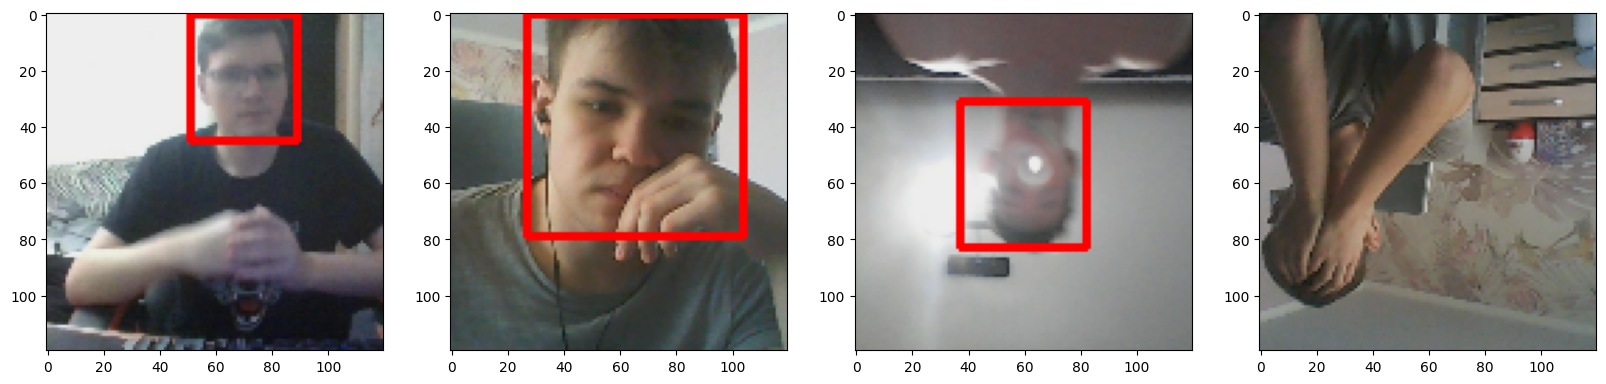

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = (test_sample[0][idx] * 240).astype(int)
    sample_coords = (yhat[1][idx] * 120).astype(int)
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      sample_coords[:2],
                      sample_coords[2:], 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [1]:
from tensorflow.keras.models import load_model

In [2]:
facetracker = load_model('facetracker_v2.h5')

In [5]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step
